In [5]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

<>:109: SyntaxWarning: invalid escape sequence '\m'
<>:109: SyntaxWarning: invalid escape sequence '\s'
<>:109: SyntaxWarning: invalid escape sequence '\m'
<>:109: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jens2\AppData\Local\Temp\ipykernel_21544\2383449530.py:109: SyntaxWarning: invalid escape sequence '\m'
  plt.title(f"HODL vs Liquidity pool vs Rebalanced, with $\mu = ${mu}, $\sigma = ${sigma}")
C:\Users\jens2\AppData\Local\Temp\ipykernel_21544\2383449530.py:109: SyntaxWarning: invalid escape sequence '\s'
  plt.title(f"HODL vs Liquidity pool vs Rebalanced, with $\mu = ${mu}, $\sigma = ${sigma}")


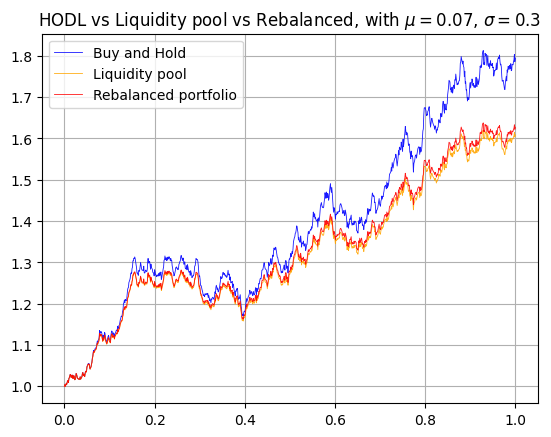

In [2]:
dt = 0.001
T = 1
t_array = np.arange(0, T+dt, dt)

mu = 0.07
sigma = 0.3
S_0 = 100

def simulate_gbm_OLD(mu, sigma, dt=0.01, T=1, S_0=100):
    t_array = np.arange(0, T+dt, dt)
    z_rand = np.random.normal(loc=0, scale=1, size=len(t_array))
    wienner_process = z_rand.cumsum()
    drift_arr = np.full(fill_value=(mu - np.pow(sigma, 2)/2)*dt, shape=len(t_array)).cumsum()

    gbm = S_0*np.exp(drift_arr + sigma*wienner_process)
    return gbm


def simulate_gbm(mu, sigma, t_array=None, dt=0.01, T=1, S_0=100):
    """
    Simulate a single path of Geometric Brownian Motion (GBM).

    Parameters
    ----------
    mu : float
        Drift coefficient (expected return)
    sigma : float
        Volatility coefficient
    t_array : array-like or None
        Optional. If provided, time points at which to simulate GBM.
        If None, generates np.arange(0, T + dt, dt).
    dt : float
        Time step size
    T : float
        Total simulation time
    S_0 : float
        Initial value (e.g., starting stock price)

    Returns
    -------
    t : np.ndarray
        Time array from 0 to T
    S : np.ndarray
        Simulated GBM values corresponding to t
    """

    # Use provided t_array or generate one
    if t_array is None:
        t_array = np.arange(0, T + dt, dt)
    else:
        dt = np.diff(t_array).mean()

    n_steps = len(t_array)
    # Generate random normal increments for Brownian motion
    dW = np.random.normal(0, np.sqrt(dt), size=n_steps - 1)
    W = np.concatenate(([0], np.cumsum(dW)))

    # Analytical GBM solution
    S = S_0 * np.exp((mu - 0.5 * sigma**2) * t_array + sigma * W)

    return S


c = 100
w_1 = 0.5
w_0 = 1 - w_1

N = 1
gbms = [simulate_gbm(mu=mu, sigma=sigma, dt=dt, T=T, S_0=S_0) for i in range(N)]
gbm_matrix = np.vstack(gbms).T
gbm_matrix = gbm_matrix / gbm_matrix[0]

# Simulating buy and hold
buy_n_hold_matrix = w_1*gbm_matrix + w_0*gbm_matrix[0]
buy_n_hold_matrix = buy_n_hold_matrix / buy_n_hold_matrix[0]

linewidth = 0.6
alpha = 0.9

for i in range(buy_n_hold_matrix.shape[1]-1):
    buy_n_hold = buy_n_hold_matrix[:, i]
    plt.plot(t_array, buy_n_hold, color='blue', alpha=alpha, linewidth=linewidth)
plt.plot(t_array, buy_n_hold_matrix[:, -1], color='blue', alpha=alpha, linewidth=linewidth, label='Buy and Hold')
#plt.hlines(y=1+np.log(gbms[-1][-1]/gbms[-1][0]), xmin=0, xmax=T)

s_matrix = c * 1/(w_0*w_1) * gbm_matrix**w_1
s_matrix = s_matrix / s_matrix[0]

for i in range(s_matrix.shape[1]-1):
    s = s_matrix[:, i]
    plt.plot(t_array, s, alpha=alpha, linewidth=linewidth, color='orange')
plt.plot(t_array, s_matrix[:, -1], alpha=alpha, linewidth=linewidth, color='orange', label='Liquidity pool')

gbm_returns_matrix = gbm_matrix[1:] / gbm_matrix[:-1]
rebalance_log_returns = np.log(w_1*gbm_returns_matrix + w_0)

rebalance_matrix = np.full(shape=gbm_matrix.shape, fill_value=np.log(100))

rebalance_matrix[1:] = rebalance_log_returns
rebalance_matrix = np.cumsum(rebalance_matrix, axis=0)
rebalance_matrix = np.exp(rebalance_matrix)
rebalance_matrix = rebalance_matrix / rebalance_matrix[0]

for i in range(rebalance_matrix.shape[1]-1):
    X = rebalance_matrix[:, i]
    plt.plot(t_array, X, alpha=alpha, linewidth=linewidth, color='red')
plt.plot(t_array, rebalance_matrix[:, -1], alpha=alpha, linewidth=linewidth, color='red', label='Rebalanced portfolio')

plt.title(f"HODL vs Liquidity pool vs Rebalanced, with $\mu = ${mu}, $\sigma = ${sigma}")
plt.grid()
plt.legend()
plt.show()

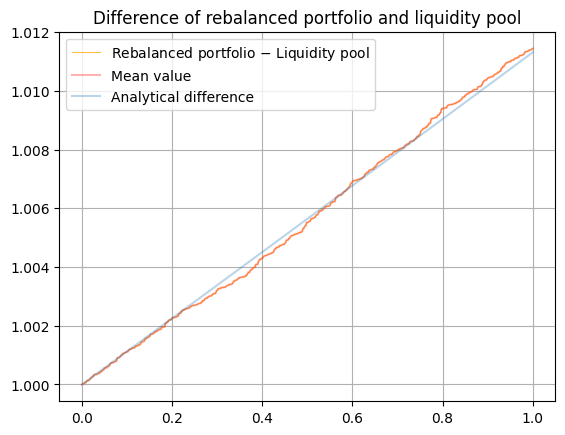

In [4]:
diff_rebalance = rebalance_matrix / s_matrix
for i in range(rebalance_matrix.shape[1]-1):
    diff_arr = diff_rebalance[:, i]
    plt.plot(t_array, diff_arr, alpha=alpha, linewidth=linewidth, color='orange')
plt.plot(t_array, diff_rebalance[:, -1], alpha=alpha, linewidth=linewidth, color='orange', label='Rebalanced portfolio $-$ Liquidity pool')

diff_rebalance_mean = np.mean(diff_rebalance, axis=1)
plt.plot(t_array, diff_rebalance_mean, color='red', label='Mean value', alpha=0.3)
plt.plot(t_array, np.exp(sigma**2*t_array/8), label='Analytical difference', alpha=0.3)

plt.title("Difference of rebalanced portfolio and liquidity pool")
plt.grid()
plt.legend()
plt.show()

In [ ]:
tickers = ['AAPL', 'MSFT', 'BTC-USD']
df = yf.download(tickers=tickers, start='2020-01-01', end='2021-01-01')
df = df[['Close']]
df = df.dropna()

N_assets = len(df.columns)
w_vector = np.ones(shape=N_assets) / N_assets

def get_lambda(df, w_vector):
    df_returns = df.pct_change().dropna() - 1
    cov_matrix = df_returns.cov().to_numpy() * 252

    a = np.dot(w_vector, np.diag(cov_matrix)) / 2
    b = w_vector @ cov_matrix @ w_vector.T / 2
    print(a, b)
    return a - b

l = get_lambda(df, w_vector)
print(l)

def compute_LP_value(df_prices, w_vector):
    return None

C:\Users\jens2\AppData\Local\Temp\ipykernel_21544\715584757.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers=tickers, start='2020-01-01', end='2021-01-01')
[*********************100%***********************]  3 of 3 completed

0.15586593529993542 0.09959868838595307
0.056267246913982355
